In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

import yfinance as yf

In [107]:
# Download the stock price data from yahoo finance
df = yf.download('GE','1970-01-02','2020-11-01')

[*********************100%***********************]  1 of 1 completed


In [108]:
# Note that there's a multi-index
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GE,GE,GE,GE,GE,GE
Date,,,,,,
1970-01-02,0.782726,3.825214,3.875135,3.818974,3.868895,464732
1970-01-05,0.778895,3.806493,3.843934,3.775292,3.825214,849338
1970-01-06,0.755911,3.694170,3.800253,3.675450,3.800253,711120
1970-01-07,0.759742,3.712891,3.762812,3.706651,3.706651,923455
1970-01-08,0.766126,3.744092,3.781533,3.725371,3.725371,2788393


In [109]:
df.columns

MultiIndex([('Adj Close', 'GE'),
            (    'Close', 'GE'),
            (     'High', 'GE'),
            (      'Low', 'GE'),
            (     'Open', 'GE'),
            (   'Volume', 'GE')],
           names=['Price', 'Ticker'])

In [110]:
# Settting the column names appropriately
df.columns = df.columns.get_level_values(0)
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1970-01-02,0.782726,3.825214,3.875135,3.818974,3.868895,464732
1970-01-05,0.778895,3.806493,3.843934,3.775292,3.825214,849338
1970-01-06,0.755911,3.694170,3.800253,3.675450,3.800253,711120
1970-01-07,0.759742,3.712891,3.762812,3.706651,3.706651,923455
1970-01-08,0.766126,3.744092,3.781533,3.725371,3.725371,2788393


In [111]:
df.reset_index(inplace=True)
df.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
0,1970-01-02,0.782726,3.825214,3.875135,3.818974,3.868895,464732
1,1970-01-05,0.778895,3.806493,3.843934,3.775292,3.825214,849338
2,1970-01-06,0.755911,3.694170,3.800253,3.675450,3.800253,711120
3,1970-01-07,0.759742,3.712891,3.762812,3.706651,3.706651,923455
4,1970-01-08,0.766126,3.744092,3.781533,3.725371,3.725371,2788393


In [112]:
df.Date = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12824 entries, 0 to 12823
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       12824 non-null  datetime64[ns]
 1   Adj Close  12824 non-null  float64       
 2   Close      12824 non-null  float64       
 3   High       12824 non-null  float64       
 4   Low        12824 non-null  float64       
 5   Open       12824 non-null  float64       
 6   Volume     12824 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 701.4 KB


**We are trying to predict the stock opening price based on all attributes, considering a 14-day moving window**

In [113]:
# Need to scale the data since some activation functions don't perform well on extreme values, note that scaler model is trained to scale 5 columns simultaneously

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.iloc[:,1:6])

In [114]:
scaled_data

array([[-0.97633435, -0.97419734, -0.97387795, -0.97414312, -0.97377977],
       [-0.97641926, -0.97447595, -0.9743373 , -0.97480081, -0.97442991],
       [-0.9769287 , -0.9761476 , -0.97498038, -0.97630405, -0.97480142],
       ...,
       [-0.18725378, -0.48073645, -0.45418243, -0.47558053, -0.4742542 ],
       [-0.19268794, -0.48444528, -0.46298769, -0.48308473, -0.46312687],
       [-0.18725378, -0.48073645, -0.47766321, -0.48458556, -0.48686523]])

In [115]:
# What is standardization? Take a value and subtract the mean of the column and divide by the standard deviation
(df.iloc[1,1] - df.iloc[:,1].mean()) / df.iloc[:,1].std(ddof=1)

np.float64(-0.9763811917512408)

In [116]:
# So ideally now we need to prepare the data, i.e we try to predict the upcoming open price based on previous 14 days feature values
# We are training the model for the entire data, there's no validation or test-data for this experiment

scaled_X = []
scaled_Y = []
window_size = 14

for i in range(len(scaled_data)-window_size):
    scaled_X.append(scaled_data[i:i+window_size,:])
    scaled_Y.append(scaled_data[i+window_size,-1])

scaled_X, scaled_Y = np.array(scaled_X), np.array(scaled_Y)

In [117]:
scaled_X.shape, scaled_Y.shape

((12810, 14, 5), (12810,))

> Training an LSTM with a 1D Output

    If you want to train an LSTM where the output layer has 1 unit (e.g., predicting a single scalar value per time step), you need to reshape the scaled_Y array to match the expected shape for training. LSTMs expect their target (Y) data to be at least 2D, where the second dimension corresponds to the number of output features.

In [118]:
scaled_Y = scaled_Y.reshape((scaled_Y.shape[0],1))
scaled_X.shape, scaled_Y.shape

((12810, 14, 5), (12810, 1))

**Note** : The train data (scaled_X) ideally has 12810 observations where each observation being a 2D array of size 14 x 5 (14 rows and 5 columns)

In [119]:
model = Sequential()
model.add(LSTM(units=64,return_sequences=True,input_shape=(scaled_X.shape[1],scaled_X.shape[2])))
model.add(LSTM(units=32,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(scaled_Y.shape[1]))
model.compile(metrics=['acc'],optimizer='adam',loss='mean_squared_error')
print(model.summary())

c:\Users\aswin\Downloads\Learning\Time Series\Deep Learning - LSTM - Multivariate\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 14, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

None


I've totally 5 features incoming to the LSTM layer while LSTM layer has 64 units. The calculation goes as follows:
 > Weights = 64*5 = 320

 > Biases = 64

 > Recursive weights = 64*64 = 4096

 > For a single gate the number of parameters = 320 + 64 + 4096 = 4480

 > Therefore for 4 gates, it's 4*4480 = 17920

 Similar calucaltion for the next layer - features:64, units:32

( (64x32) weights + 32 biases + 32x32 recursive weights )*4 = 12416 parameters

In [120]:
len(scaled_X)

12810

In [121]:
# Now we have the model architecture in place, it's time to train our model

history = model.fit(scaled_X,scaled_Y,validation_split=0.1,epochs=10,batch_size=16)

Epoch 1/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - acc: 0.0000e+00 - loss: 0.0460 - val_acc: 0.0000e+00 - val_loss: 0.0019
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.0000e+00 - loss: 0.0124 - val_acc: 0.0000e+00 - val_loss: 0.0010
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.0000e+00 - loss: 0.0112 - val_acc: 0.0000e+00 - val_loss: 8.4988e-04
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.0000e+00 - loss: 0.0102 - val_acc: 0.0000e+00 - val_loss: 0.0017
Epoch 5/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.0000e+00 - loss: 0.0099 - val_acc: 0.0000e+00 - val_loss: 9.2851e-04
Epoch 6/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.0000e+00 - loss: 0.0097 - val_acc: 0.0000e+00 - val_loss: 7.6444e-04
Epoch 7/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.0000e+00 - loss: 0.0103 - val_acc: 0.0000e+00 - val_loss: 0.0014
Epoch 8/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.0000e+00 - loss: 0.0099 - val_acc: 0.0000e+00

What is Batch Size?

Batch size refers to the number of samples (rows of data) that the model processes in a single forward and backward pass.
After processing each batch, the model updates its weights using the computed loss.
Types of Batch Sizes
Small Batch Size (e.g., 1 or 16):

Fewer samples per batch.
Requires more updates (iterations) to complete one epoch.
May generalize better but takes longer to train.
Large Batch Size (e.g., 64, 128, or more):

More samples per batch.
Requires fewer updates to complete an epoch.
Training is faster but can converge to poorer solutions.

Let's say we have hundred samples with 20 as batch-size. So to complete one epoch the weights are updated 5 times

Here 721 refers to the number of batches for each epoch. Note that we use only 90% of the data for training and rest 10% for validation. Hence, the number os samples utilized for training is 0.9*12810 = 11529. Since batch size is 16, the number of batches = 11529/16 = 721

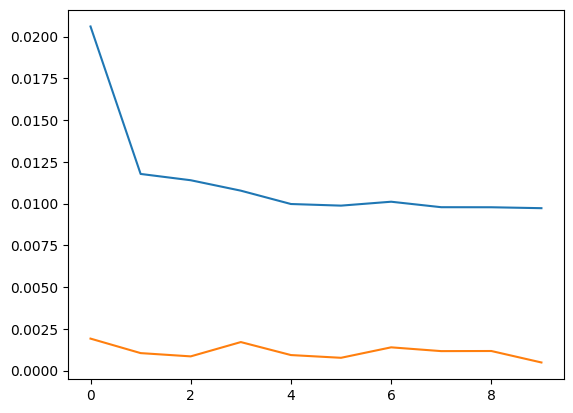

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [129]:
y_preds = model.predict(scaled_X)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Need to compute the model performance on the overall data

In [ ]:
# Error since scaler was trained on 5 columns while inverting our data has only 1 column
scaler.inverse_transform(scaled_Y)

ValueError: non-broadcastable output operand with shape (12810,1) doesn't match the broadcast shape (12810,5)

In [139]:
# Note that the scaler transformation model was trained on 5 columns while we the data that needs to be inverted has only 1 column

y_actual_inverse = scaler.inverse_transform(np.repeat(scaled_Y,5,axis=1))[:,-1]
y_preds_inverse = scaler.inverse_transform(np.repeat(y_preds,5,axis=1))[:,-1]

In [ ]:
# Model evaluation metrics
root_mean_squared_error(y_actual_inverse,y_preds_inverse)

np.float64(1.3340267881446726)

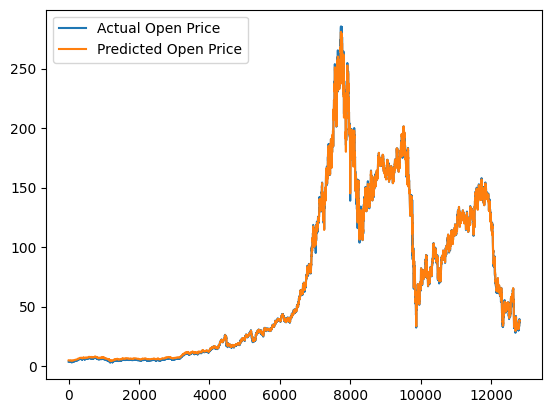

In [143]:
plt.plot(y_actual_inverse)
plt.plot(y_preds_inverse)
plt.legend(['Actual Open Price','Predicted Open Price'],loc='upper left')

In [150]:
df.Date[-100:]

12724   2020-06-11
12725   2020-06-12
12726   2020-06-15
12727   2020-06-16
12728   2020-06-17
           ...    
12819   2020-10-26
12820   2020-10-27
12821   2020-10-28
12822   2020-10-29
12823   2020-10-30
Name: Date, Length: 100, dtype: datetime64[ns]

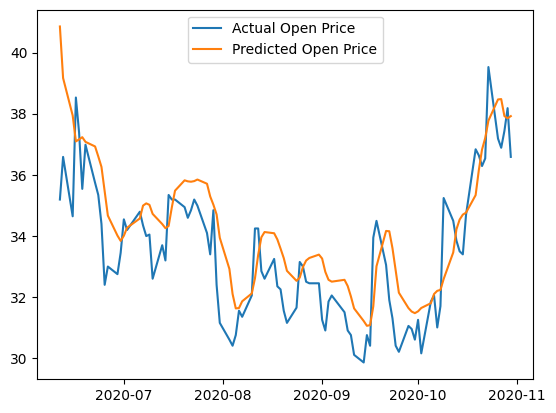

In [151]:
plt.plot(df.Date[-100:],y_actual_inverse[-100:])
plt.plot(df.Date[-100:],y_preds_inverse[-100:])
plt.legend(['Actual Open Price','Predicted Open Price'],loc='upper center')

In [148]:
df.Date.max()

Timestamp('2020-10-30 00:00:00')

#### Forecast for the future

**Now let's predict the open price of the stock in future - On 31st October 2020, we need to first create the test observation**

In [156]:
# Extracting the last 14 observations from the scaled data 
test_obs = scaled_data[-14:,:]
test_obs

array([[-0.26333202, -0.53266003, -0.5304949 , -0.53186204, -0.52766545],
       [-0.25246387, -0.52524238, -0.52535845, -0.52735956, -0.53285825],
       [-0.24702946, -0.5215335 , -0.52609224, -0.53561414, -0.53434188],
       [-0.20138277, -0.4903794 , -0.49160487, -0.51085027, -0.51505448],
       [-0.20138277, -0.4903794 , -0.48279961, -0.4890881 , -0.48315611],
       [-0.19594852, -0.48667058, -0.48646847, -0.48608639, -0.48612338],
       [-0.19812227, -0.4881541 , -0.48720227, -0.48608639, -0.49131618],
       [-0.1546489 , -0.45848352, -0.46225395, -0.48233429, -0.48760701],
       [-0.16443031, -0.46515938, -0.4417083 , -0.46432417, -0.44309768],
       [-0.19160102, -0.48370355, -0.47619562, -0.485336  , -0.47796337],
       [-0.22203232, -0.50447291, -0.48793601, -0.49959396, -0.48241427],
       [-0.18725378, -0.48073645, -0.45418243, -0.47558053, -0.4742542 ],
       [-0.19268794, -0.48444528, -0.46298769, -0.48308473, -0.46312687],
       [-0.18725378, -0.48073645, -0.4

In [158]:
test_obs.shape

(14, 5)

In [159]:
scaled_X.shape

(12810, 14, 5)

In [157]:
model.predict(test_obs)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [162]:
# Model expects the data to be in 3 dimensions

test_obs_reshaped = test_obs.reshape(1,test_obs.shape[0],test_obs.shape[1])
test_obs_reshaped.shape

(1, 14, 5)

In [164]:
# Now let's try to predict the data
future_pred = model.predict(test_obs_reshaped)
future_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[-0.4673099]], dtype=float32)

In [169]:
np.repeat(future_pred,5,axis=1)

array([[-0.4673099, -0.4673099, -0.4673099, -0.4673099, -0.4673099]],
      dtype=float32)

In [173]:
future_pred_inverse = scaler.inverse_transform(np.repeat(future_pred,5,axis=1))[:,-1]
future_pred_inverse[0]

np.float32(37.897427)

**So the forecasted stock open price on the 31st of October 2020 is 37.897 rupees**

**Note**:

> We can forecast beyond one day becasue we don't have the data corresponding to it.

> E.g: Let's say today is 30-10-2020 and we are predicting the stock open-price on 31-10-2020. To predict the stock price on 01-11-2020 we require the close, adj close, high, low while only open(prediction on 31-10-2020) is available. Hence, we cannot forecast beyond one day in muti-variate time series models unless the future values of these exogenous variables are known.